In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import pickle

import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
main_path=r'D:\python data\cv_flowers recognition\flowers'

In [3]:
categories=[]
for category in os.listdir(main_path):
    if os.path.isdir(os.path.join(main_path,category)):
        categories.append(category)
categories

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

for img_class in categories:
    for img_file in os.listdir(os.path.join(main_path,img_class)):
        img_path=os.path.join(main_path,img_class,img_file)
        try:
            img=cv2.imread(img_path)
            img=cv2.resize(img,(256,256))
        except:
            print(f'issue with {img_file}')

In [4]:
data=tf.keras.utils.image_dataset_from_directory(main_path,batch_size=64,shuffle=True,seed=12)


Found 4317 files belonging to 5 classes.


In [5]:
data=data.map(lambda x,y:(x/255,y))

In [6]:
scaled_iterator=data.as_numpy_iterator()

In [7]:
batch=scaled_iterator.next()

In [8]:
batch[0].shape

(64, 256, 256, 3)

In [9]:
batch[1]

array([1, 3, 3, 1, 0, 1, 0, 1, 1, 0, 1, 3, 3, 3, 0, 1, 1, 2, 1, 1, 0, 1,
       4, 3, 4, 1, 0, 2, 0, 1, 1, 2, 2, 4, 2, 2, 0, 2, 4, 2, 3, 1, 0, 1,
       2, 1, 2, 4, 0, 3, 2, 1, 0, 3, 1, 0, 3, 1, 4, 2, 4, 1, 2, 2])

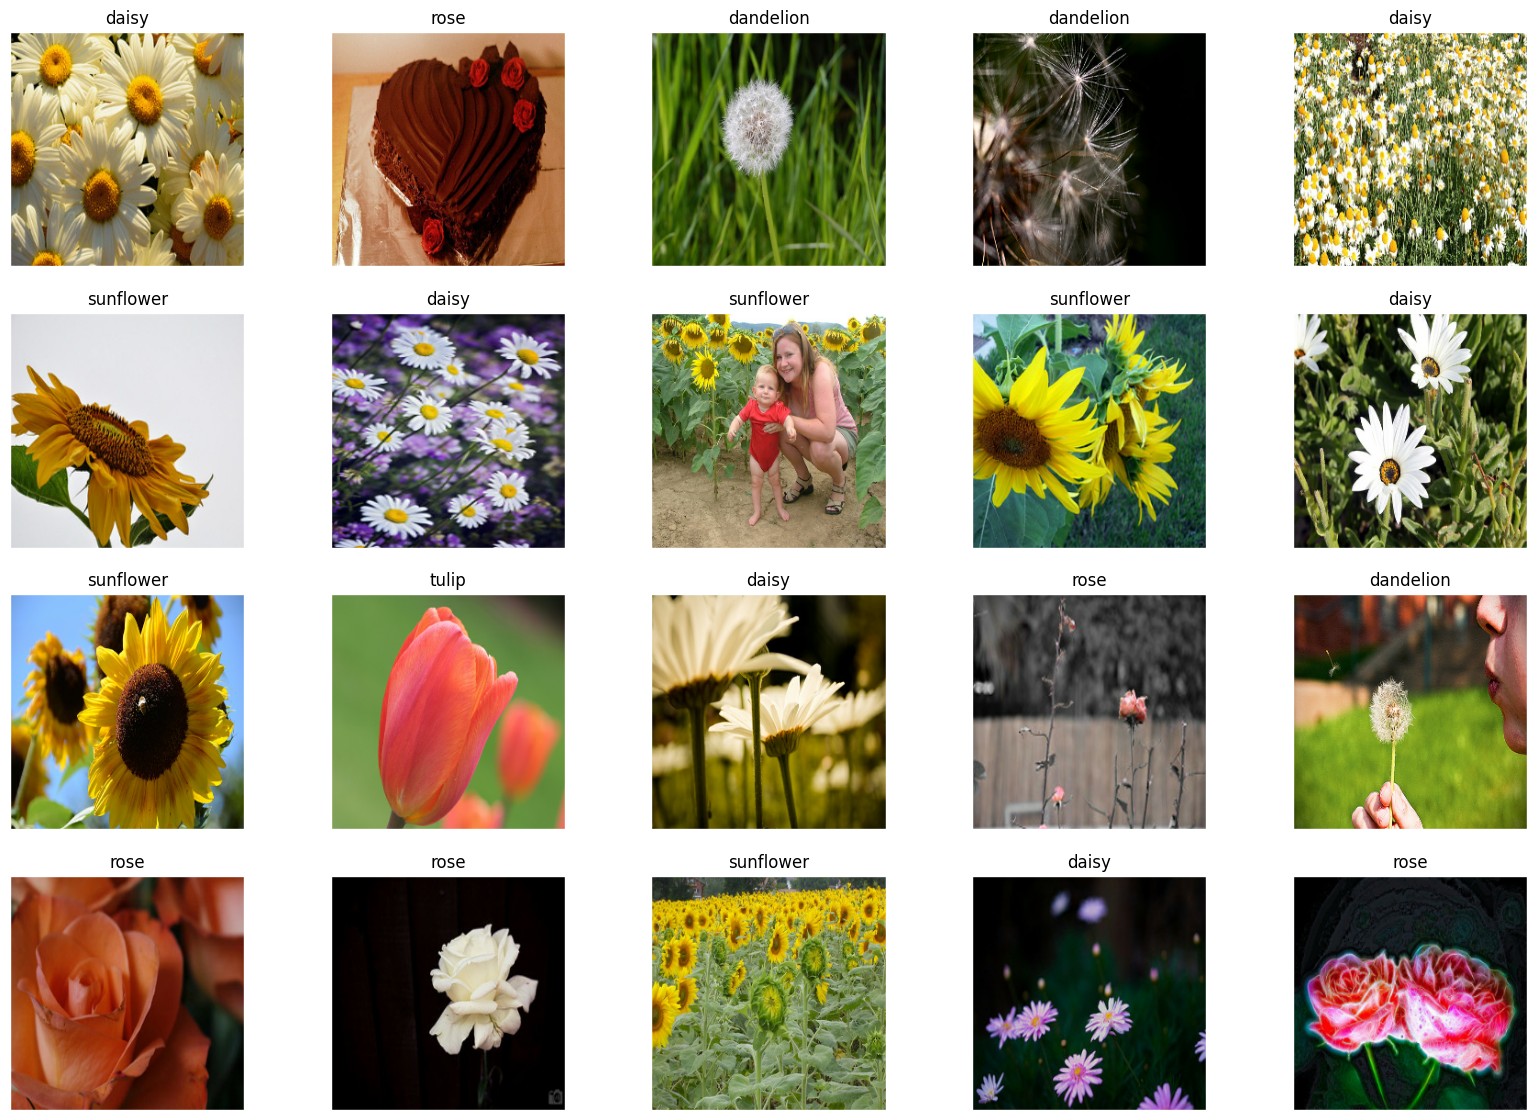

In [10]:
import random

fig,axes=plt.subplots(4,5,figsize=(20,14))
for i,index in enumerate(random.sample(range(len(batch[0])),20)):
    ax=axes.flatten()[i]
    ax.imshow(batch[0][index])
    ax.set_title(categories[batch[1][index]],size=12)
    ax.set_xticks([]), ax.set_yticks([])

In [11]:
len(data)

68

In [12]:
train_size=int(len(data)*0.8)
val_size=int(len(data)*0.1)
test_size=len(data)-train_size-val_size

print(train_size+val_size+test_size==len(data))
train_size,val_size,test_size


True


(54, 6, 8)

In [13]:
train_data=data.take(train_size)
val_data=data.skip(train_size).take(val_size)
test_data=data.skip(train_size+val_size).take(test_size)

In [14]:
print(len(train_data),len(val_data),len(test_data))

54 6 8


In [15]:
from keras.models import Sequential
from keras.layers import Input, Conv2D,MaxPooling2D,MaxPooling3D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
model = Sequential()

# Convolutional layers
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())


# Dense layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))


model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              #optimizer=Adam(learning_rate=0.001),  # Experiment with learning rate
              metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5)

logdir='D:\python data\cv_flowers recognition\model\logs'
tensorboard_callbakcs=tf.keras.callbacks.TensorBoard(log_dir=logdir)


model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 64)      

In [17]:
#hist=model.fit(train_data,epochs=20,validation_data=val_data,callbacks=[tensorboard_callbakcs])


In [18]:
#pickle.dump(hist,open(os.path.join(os.path.dirname(main_path),'hist.pickle'),'wb'))
#pickle.dump(model,open(os.path.join(os.path.dirname(main_path),'model.h5'),'wb'))

In [19]:
hist=pickle.load(open(os.path.join(os.path.dirname(main_path),'hist.pickle'),'rb'))
model=pickle.load(open(os.path.join(os.path.dirname(main_path),'model.h5'),'rb'))

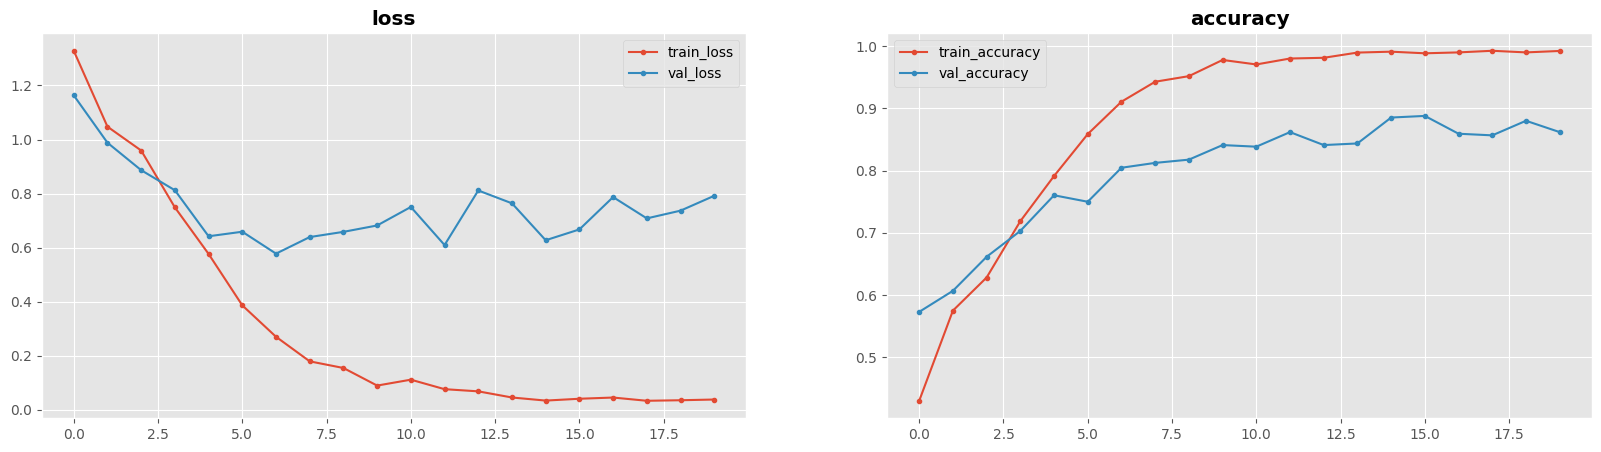

In [20]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,5))

ax1.plot(hist.history['loss'],label='train_loss',marker='.')
ax1.plot(hist.history['val_loss'],label='val_loss',marker='.')
ax1.set_title('loss',fontweight='bold')
ax1.legend()

ax2.plot(hist.history['accuracy'],label='train_accuracy',marker='.')
ax2.plot(hist.history['val_accuracy'],label='val_accuracy',marker='.')
ax2.set_title('accuracy',fontweight='bold')
ax2.legend()

plt.show()

In [21]:
model.evaluate(test_data)



8/8 [==============================] - 8s 601ms/step - loss: 1.2067 - accuracy: 0.8029


[1.2067145109176636, 0.802935004234314]

In [22]:
test_prediction=model.predict(test_data)
test_prediction=np.argmax(test_prediction, axis=1)

8/8 [==============================] - 4s 310ms/step


In [23]:
y_test = np.concatenate([y_batch for X_batch, y_batch in test_data],axis=-1)

In [24]:
from sklearn import metrics

metrics.accuracy_score(test_prediction,y_test)

0.1949685534591195

<Axes: >

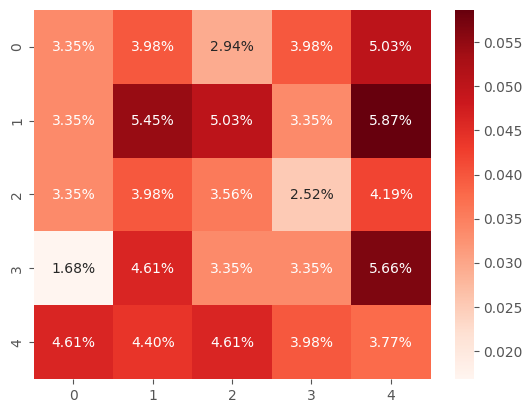

In [25]:
cm=metrics.confusion_matrix(test_prediction,y_test)
cm=cm/cm.sum()

import seaborn

seaborn.heatmap(cm,annot=True,fmt='.2%',cmap='Reds')

In [30]:
[y_batch for X_batch, y_batch in test_data]

[<tf.Tensor: shape=(64,), dtype=int32, numpy=
 array([3, 0, 4, 3, 4, 4, 3, 1, 2, 4, 4, 4, 1, 2, 3, 2, 2, 3, 1, 4, 4, 4,
        3, 0, 1, 2, 1, 2, 0, 1, 1, 1, 0, 1, 1, 1, 3, 1, 2, 2, 0, 2, 1, 4,
        2, 3, 4, 1, 4, 0, 4, 1, 1, 0, 2, 4, 0, 4, 1, 2, 0, 2, 1, 0])>,
 <tf.Tensor: shape=(64,), dtype=int32, numpy=
 array([4, 3, 1, 3, 3, 2, 2, 4, 1, 4, 0, 1, 1, 3, 2, 4, 1, 2, 1, 4, 3, 0,
        4, 3, 0, 1, 3, 4, 4, 3, 0, 1, 2, 3, 4, 0, 3, 2, 1, 4, 1, 1, 3, 4,
        0, 0, 3, 1, 1, 1, 4, 4, 2, 4, 0, 0, 3, 2, 4, 0, 4, 4, 2, 1])>,
 <tf.Tensor: shape=(64,), dtype=int32, numpy=
 array([3, 4, 1, 0, 1, 1, 3, 2, 0, 3, 4, 4, 4, 3, 3, 0, 4, 2, 4, 4, 4, 0,
        0, 1, 4, 4, 4, 3, 1, 4, 3, 2, 3, 4, 2, 1, 4, 1, 0, 4, 2, 4, 1, 4,
        0, 1, 1, 1, 3, 2, 0, 2, 2, 3, 1, 2, 3, 4, 2, 3, 1, 0, 3, 2])>,
 <tf.Tensor: shape=(64,), dtype=int32, numpy=
 array([4, 4, 4, 2, 2, 1, 4, 3, 2, 2, 4, 4, 3, 1, 4, 4, 0, 4, 1, 0, 2, 0,
        3, 1, 1, 2, 1, 3, 4, 2, 1, 2, 2, 4, 1, 2, 3, 4, 3, 2, 1, 0, 0, 0,
        3, 